In [3]:
# Import libraries
import matplotlib.pyplot as plt
import pandas as pd
import os

from surprise import AlgoBase
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise import SVD
import re
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [4]:
# load and view data
data = pd.read_csv('ppp BTRec.csv')
print(f"Shape of the data is: {data.shape}")
data.head()

Shape of the data is: (416995, 3)


,Lender,BTCode,Rating
0,"\tFarm Credit of Western Oklahoma, ACA",4,1
1,1st Bank in Hominy,1,1
2,1st Bank Yuma,4,1
3,1st Bank Yuma,3,1
4,1st Bank Yuma,3,1


In [5]:
# investigate rows with null values
data[data.isnull().any(axis=1)]

,Lender,BTCode,Rating


In [6]:
# drop lenders with loans of 5 or more
counts = data['Lender'].value_counts()

loan_data_top = data.loc[data['Lender'].isin(counts.index[counts > 5])]
loan_data_top.shape

loan_data_top.head()


,Lender,BTCode,Rating
5,1st Choice CU,9,1
6,1st Choice CU,4,1
7,1st Choice CU,4,1
8,1st Choice CU,3,1
9,1st Choice CU,9,1


In [7]:
# creating own algorithm
class MyOwnAlgorithm(AlgoBase):
    
    def __init__(self):
        
        #note from example surprise.readthedocs.io" says always call base method before doing anything
        AlgoBase.__init__(self)
    
    def estimate(self, u, i):
        
        return 3

algo = MyOwnAlgorithm()

cross_validate(algo, data, verbose=True)

AttributeError: 'DataFrame' object has no attribute 'raw_ratings'

In [10]:
# Assign X (data) and y(target)
X = loan_data_top.drop("Lender", axis=1)
y = loan_data_top["Lender"]
print(X.shape, y.shape)

(415265, 2) (415265,)


In [11]:
# Split our data into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)

NameError: name 'train_test_split' is not defined

In [11]:
# Create a logistic Regression Model
classifier = LogisticRegression()
classifier

LogisticRegression()

In [12]:
# Fit model using the training data
classifier.fit(X_train, y_train)

LogisticRegression()

In [13]:
# evaluate the model's performance using the test data
print(f"Training Data Score: {classifier.score(X_train, y_train)}")
print(f"Testing Data Score: {classifier.score(X_test, y_test)}")

Training Data Score: 0.6623376623376623
Testing Data Score: 0.5384615384615384


In [14]:
# Make predictions
predictions = classifier.predict(X_test)
print(f"First 10 Predictions:   {predictions[:10]}")
print(f"First 10 Actual labels: {y_test[:10].tolist()}")

First 10 Predictions:   ['AccessBank Texas' 'Accion' 'AccessBank Texas' 'AccessBank Texas'
 'Accion' 'AccessBank Texas' 'AccessBank Texas' 'AccessBank Texas'
 'AccessBank Texas' 'AccessBank Texas']
First 10 Actual labels: ['Accion', 'AccessBank Texas', 'Accion', 'Accion', 'Accion', 'AccessBank Texas', 'Accion', 'Accion', 'AccessBank Texas', 'AccessBank Texas']


In [15]:
# View predictions along with their probabilities of being within each class 
##  this will be the difficult part of our project because data is not binary like example: male/female
probs = classifier.predict_proba(X_test)
pred_df = pd.DataFrame({
    "Prediction": predictions, 
    "Actual": y_test, 
    "P(Female)": [p[0] for p in probs], 
    "P(Male)": [p[1] for p in probs]
    }).reset_index(drop=True)

pred_df.head(10)

,Prediction,Actual,P(Female),P(Male)
0,AccessBank Texas,Accion,0.534832,0.465168
1,Accion,AccessBank Texas,0.160953,0.839047
2,AccessBank Texas,Accion,0.542506,0.457494
3,AccessBank Texas,Accion,0.533929,0.466071
4,Accion,Accion,0.436384,0.563616
5,AccessBank Texas,AccessBank Texas,0.534308,0.465692
6,AccessBank Texas,Accion,0.540750,0.459250
7,AccessBank Texas,Accion,0.542287,0.457713
8,AccessBank Texas,AccessBank Texas,0.531706,0.468294
9,AccessBank Texas,AccessBank Texas,0.534386,0.465614


In [16]:
# Model Evaluation
# Create a Confusion Matrix
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test,predictions)

array([[12,  2],
       [10,  2]], dtype=int64)

In [17]:
# Label the confusion Matrix
tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
print(f"True Neg: {tn}   False Pos: {fp}")
print(f"False Neg: {fn}  True Pos: {tp}")

True Neg: 12   False Pos: 2
False Neg: 10  True Pos: 2


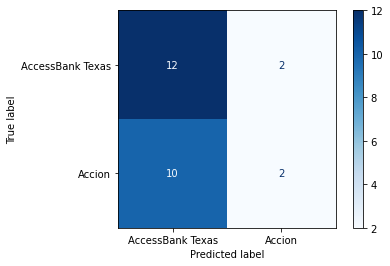

In [18]:
# Plot confusion matrix
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(classifier, X_test, y_test, cmap="Blues")

In [19]:
# Precision and Recall
### we don't technically have a "positive" label, like we would if we were classifying emails as Spam, or patients as having cancer. 
## This means that we need to tell our precision and recall functions which class label we want to consider to be our "positive" class i.e. which lender
from sklearn.metrics import precision_score, recall_score, f1_score

In [20]:
## Random tests of lenders first test is AccessBank Texas, the lender with the most loans
precision_score(y_test, predictions, pos_label="AccessBank Texas")

0.5454545454545454

In [21]:
## Random tests of lenders second test is Accion, random test of lender with lower loan count of 10 loans
precision_score(y_test, predictions, pos_label="Accion")

0.5

In [22]:
#  what is the harmonic mean of AccessBank Texas from first test
f1_score(y_test, predictions, pos_label="AccessBank Texas")

0.6666666666666665

In [23]:
#  what is the harmonic mean of Accion from second test
f1_score(y_test, predictions, pos_label="Accion")

0.25